# HMM with Poisson observations for detecting changepoints in the rate of a signal

**WARNING: This notebook needs to be updated per the latest dynamax refactor!**

Based on https://www.tensorflow.org/probability/examples/Multiple_changepoint_detection_and_Bayesian_model_selection


In [2]:
try:
    import dynamax
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/dynamax.git
    import dynamax

In [3]:
import jax.numpy as jnp
import jax.random as jr
from jax import jit, lax, vmap, value_and_grad

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import optax
from itertools import count
from functools import partial
from matplotlib import pylab as plt

from dynamax.hidden_markov_model import PoissonHMM, HMM
from dynamax.parameters import ParameterProperties

## Data

The synthetic data corresponds to a single time series of counts, where the rate of the underlying generative process changes at certain points in time.

Text(0, 0.5, 'count')

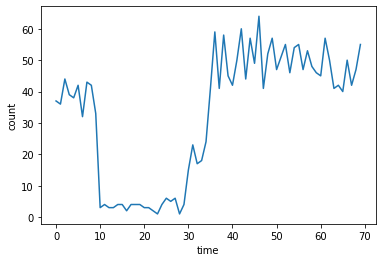

In [4]:
true_rates = [40, 3, 20, 50]
true_durations = [10, 20, 5, 35]
keys = map(jr.PRNGKey, count())

emissions = jnp.concatenate(
    [
        jr.poisson(key, rate, (num_steps,))
        for (key, rate, num_steps) in zip(keys, true_rates, true_durations)
    ]
).astype(jnp.float32)

# PoissonHMM requires are least 1D emissions
emissions = emissions[:, None]

plt.plot(emissions)
plt.xlabel("time")
plt.ylabel("count")

# Make a Poisson HMM with a log normal prior

We could use a gamma prior, but for the purposes of illustration, we'll make a Poisson HMM with a nonconjugate, log normal prior instead.

In [5]:
class NonconjugatePoissonHMM(PoissonHMM):
    """A Poisson HMM with a nonconjugate prior.    
    """
    def __init__(self, num_states, emission_dim, 
                 initial_probs_concentration=1.1,
                 transition_matrix_concentration=1.1,
                 emission_prior_loc=0.0,
                 emission_prior_scale=1.0):
        HMM.__init__(self,
            num_states, 
            initial_probs_concentration=initial_probs_concentration,
            transition_matrix_concentration=transition_matrix_concentration)
        self.emission_dim = emission_dim
        self.emission_prior_loc = emission_prior_loc
        self.emission_prior_scale = emission_prior_scale
        
    def initialize(self, key, method="prior", initial_probs=None, transition_matrix=None, rates=None):
        key1, key2 = jr.split(key)
        params, props = HMM.initialize(self, key=key1, 
                                               method=method, 
                                               initial_probs=initial_probs, 
                                               transition_matrix=transition_matrix)
        
        if rates is None:
            prior = tfd.LogNormal(self.emission_prior_loc, self.emission_prior_scale)
            rates = prior.sample(seed=key2, sample_shape=(self.num_states, self.emission_dim))
            
        params['emissions'] = dict(rates=rates)
        props['emissions'] = dict(rates=ParameterProperties(constrainer=tfb.Softplus()))
        return params, props
        
    def log_prior(self, params):
        return tfd.LogNormal(self.emission_prior_loc, self.emission_prior_scale).log_prob(
            params["emissions"]["rates"]
        ).sum()
        
    # Default to the standard E and M steps rather than the conjugate updates
    # for the PoissonHMM with a gamma prior.
    def e_step(self, params, batch_emissions):
        return StandardHMM.e_step(self, params, batch_emissions)
    
    def m_step(self, params, param_props, batch_emissions, batch_posteriors, **batch_covariates):
        return StandardHMM.m_step(self, params, param_props, batch_emissions, batch_posteriors, **batch_covariates)

## Model with fixed $K$

To model the changing Poisson rate, we use an HMM. We initially assume the number of states is known to be $K=4$. Later we will try comparing HMMs with different $K$.

We fix the initial state distribution to be uniform, and fix the transition matrix to be the following, where we set $p=0.05$:

$$ \begin{align*} z_1 &\sim \text{Categorical}\left(\left\{\frac{1}{4}, \frac{1}{4}, \frac{1}{4}, \frac{1}{4}\right\}\right)\\ z_t | z_{t-1} &\sim \text{Categorical}\left(\left\{\begin{array}{cc}p & \text{if } z_t = z_{t-1} \\ \frac{1-p}{4-1} & \text{otherwise}\end{array}\right\}\right) \end{align*}$$

In [6]:
def build_latent_state(num_states, max_num_states, daily_change_prob):
    # Give probability 0 to states outside of the current model.
    def prob(s):
        return jnp.where(s < num_states + 1, 1 / num_states, 0.0)

    states = jnp.arange(1, max_num_states + 1)
    initial_state_probs = vmap(prob)(states)

    # Build a transition matrix that transitions only within the current
    # `num_states` states.
    def transition_prob(i, s):
        return jnp.where(
            (s <= num_states) & (i <= num_states) & (1 < num_states),
            jnp.where(s == i, 1 - daily_change_prob, daily_change_prob / (num_states - 1)),
            jnp.where(s == i, 1, 0),
        )

    transition_probs = vmap(transition_prob, in_axes=(None, 0))(states, states)

    return initial_state_probs, transition_probs

In [7]:
num_states = 4
daily_change_prob = 0.05

initial_state_probs, transition_probs = build_latent_state(num_states, num_states, daily_change_prob)
print("Initial state probs:\n{}".format(initial_state_probs))
print("Transition matrix:\n{}".format(transition_probs))

Initial state probs:
[0.25 0.25 0.25 0.25]
Transition matrix:
[[0.95       0.01666667 0.01666667 0.01666667]
 [0.01666667 0.95       0.01666667 0.01666667]
 [0.01666667 0.01666667 0.95       0.01666667]
 [0.01666667 0.01666667 0.01666667 0.95      ]]


Now we create an HMM where the observation distribution is a Poisson with learnable parameters. We specify the parameters in log space and initialize them to random values around the log of the overall mean count (to set the scal

## Model fitting using Gradient Descent

We compute a MAP estimate of the Poisson rates $\lambda$ using batch gradient descent, using the Adam optimizer applied to the log likelihood (from the HMM) plus the log prior for $p(\lambda)$.

In [8]:
# Define variable to represent the unknown log rates.
hmm = NonconjugatePoissonHMM(num_states, 
                             emission_dim=1, 
                             emission_prior_loc=jnp.log(emissions.mean()), 
                             emission_prior_scale=1.0)

# The optimization gets stuck in local optima. This key should find the right states.
params, param_props = hmm.initialize(jr.PRNGKey(1),
                                     initial_probs=initial_state_probs,
                                     transition_matrix=transition_probs)

# Freeze the initial distribution and transition matrix
param_props["initial"]["probs"].trainable = False
param_props["transitions"]["transition_matrix"].trainable = False

# Fit the model with SGD
optimizer = optax.adam(1e-1)
num_epochs = 1000
params, losses = hmm.fit_sgd(params,
                     param_props,
                     emissions,
                     optimizer=optimizer,
                     num_epochs=num_epochs)

Text(0.5, 0, 'iteration')

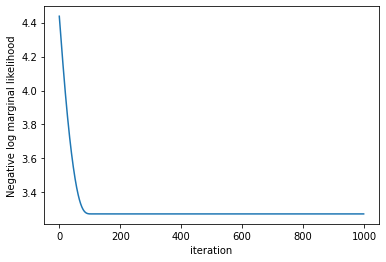

In [9]:
plt.plot(losses)
plt.ylabel("Negative log marginal likelihood")
plt.xlabel("iteration")

In [10]:
print("Inferred rates: {}".format(params["emissions"]["rates"]))
print("True rates: {}".format(true_rates))

Inferred rates: [[49.42945 ]
 [ 3.560795]
 [38.529095]
 [19.30307 ]]
True rates: [40, 3, 20, 50]


We see that the rates are the same for some states, which means those states are being treated as identical, and are therefore redundant. This is evidence of EM getting stuck in a local optimum.

## Plotting the posterior over states

In [11]:
hmm_posterior = hmm.smoother(params, emissions)
posterior_probs = hmm_posterior.smoothed_probs
rates = params["emissions"]["rates"]

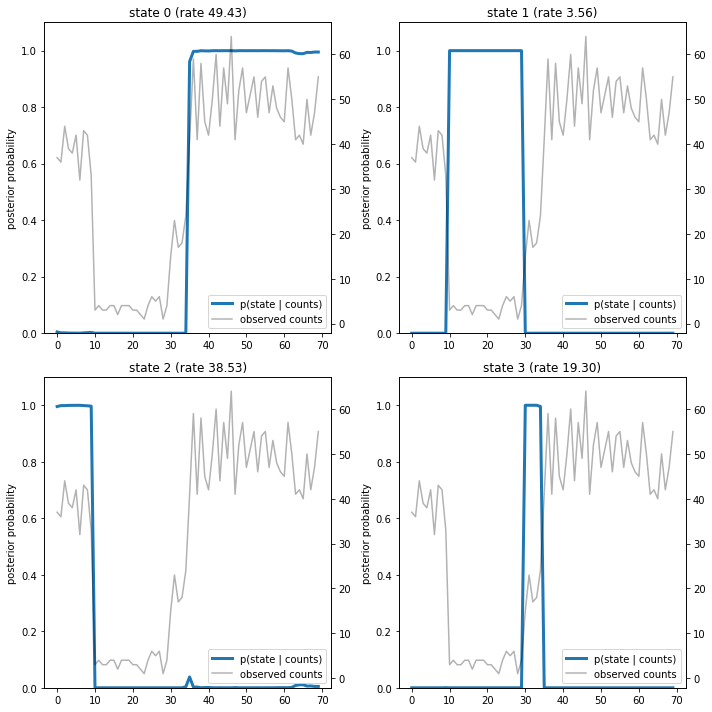

In [12]:
def plot_state_posterior(ax, state_posterior_probs, title):
    ln1 = ax.plot(state_posterior_probs, c="tab:blue", lw=3, label="p(state | counts)")
    ax.set_ylim(0.0, 1.1)
    ax.set_ylabel("posterior probability")
    ax2 = ax.twinx()
    ln2 = ax2.plot(emissions, c="black", alpha=0.3, label="observed counts")
    ax2.set_title(title)
    ax2.set_xlabel("time")
    lns = ln1 + ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=4)
    ax.grid(True, color="white")
    ax2.grid(False)


fig = plt.figure(figsize=(10, 10))
plot_state_posterior(fig.add_subplot(2, 2, 1), posterior_probs[:, 0], title="state 0 (rate {:.2f})".format(rates[0,0]))
plot_state_posterior(fig.add_subplot(2, 2, 2), posterior_probs[:, 1], title="state 1 (rate {:.2f})".format(rates[1,0]))
plot_state_posterior(fig.add_subplot(2, 2, 3), posterior_probs[:, 2], title="state 2 (rate {:.2f})".format(rates[2,0]))
plot_state_posterior(fig.add_subplot(2, 2, 4), posterior_probs[:, 3], title="state 3 (rate {:.2f})".format(rates[3,0]))
plt.tight_layout()

In [13]:
# max marginals
most_probable_states = hmm.most_likely_states(params, emissions)
most_probable_rates = rates[most_probable_states]

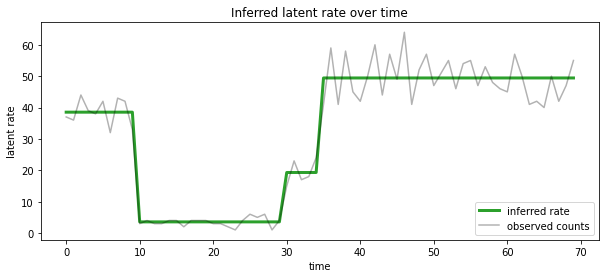

In [14]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(most_probable_rates, c="tab:green", lw=3, label="inferred rate")
ax.plot(emissions, c="black", alpha=0.3, label="observed counts")
ax.set_ylabel("latent rate")
ax.set_xlabel("time")
ax.set_title("Inferred latent rate over time")
ax.legend(loc=4);

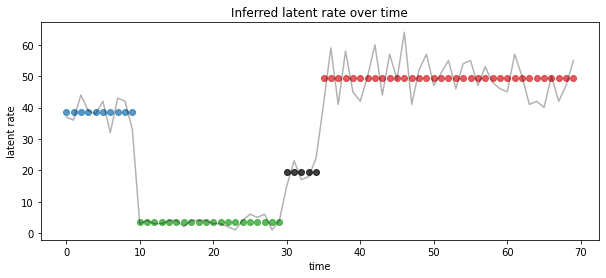

In [15]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 1, 1)
color_list = ["tab:red", "tab:green", "tab:blue", "k"]
colors = [color_list[z] for z in most_probable_states]
for i in range(len(colors)):
    ax.plot(i, most_probable_rates[i], "-o", c=colors[i], lw=3, alpha=0.75)
ax.plot(emissions, c="black", alpha=0.3, label="observed counts")
ax.set_ylabel("latent rate")
ax.set_xlabel("time")
ax.set_title("Inferred latent rate over time");

## Model with unknown $K$

In general we don't know the true number of states. One way to select the 'best' model is to compute the one with the maximum marginal likelihood. Rather than summing over both discrete latent states and integrating over the unknown parameters $\lambda$, we just maximize over the parameters (empirical Bayes approximation).

$$p(x_{1:T}|K) \approx \max_\lambda \int p(x_{1:T}, z_{1:T} | \lambda, K) dz$$
We can do this by fitting a bank of separate HMMs in parallel, one for each value of $K$. We need to make them all the same size so we can batch them efficiently. To do this, we pad the transition matrices (and other paraemeter vectors) so they all have the same shape, and then use masking.

In [16]:
max_num_states = 6
states = jnp.arange(1, max_num_states + 1)

# For each candidate model, build the initial state prior and transition matrix.
batch_initial_state_probs, batch_transition_probs = vmap(build_latent_state, in_axes=(0, None, None))(
    states, max_num_states, daily_change_prob
)

print("Shape of initial_state_probs: {}".format(batch_initial_state_probs.shape))
print("Shape of transition probs: {}".format(batch_transition_probs.shape))
print("Example initial state probs for num_states==3:\n{}".format(batch_initial_state_probs[2, :]))
print("Example transition_probs for num_states==3:\n{}".format(batch_transition_probs[2, :, :]))

Shape of initial_state_probs: (6, 6)
Shape of transition probs: (6, 6, 6)
Example initial state probs for num_states==3:
[0.33333334 0.33333334 0.33333334 0.         0.         0.        ]
Example transition_probs for num_states==3:
[[0.95  0.025 0.025 0.    0.    0.   ]
 [0.025 0.95  0.025 0.    0.    0.   ]
 [0.025 0.025 0.95  0.    0.    0.   ]
 [0.    0.    0.    1.    0.    0.   ]
 [0.    0.    0.    0.    1.    0.   ]
 [0.    0.    0.    0.    0.    1.   ]]


## Model fitting with gradient descent

In [17]:
hmm = NonconjugatePoissonHMM(max_num_states, emission_dim=1, 
                             emission_prior_loc=3.0,
                             emission_prior_scale=1.0)

def _fit(initial_probs, transition_matrix):
    # Set and freeze the initial distribution and transition matrix
    k1, k2 = jr.split(jr.PRNGKey(0), 2)
    params, param_props = hmm.initialize(key=k1, 
                                         initial_probs=initial_probs,
                                         transition_matrix=transition_matrix)
    
    # Freeze the initial probabilities and transition matrix
    param_props["initial"]["probs"].trainable = False
    param_props["transitions"]["transition_matrix"].trainable = False
    
    # Fit the model with SGD
    optimizer = optax.adam(1e-1)
    num_epochs = 1000
    return hmm.fit_sgd(params, param_props, emissions, optimizer=optimizer, num_epochs=num_epochs)

In [18]:
params, losses =vmap(_fit)(
    batch_initial_state_probs, 
    batch_transition_probs
)
rates = params["emissions"]["rates"]

Text(0, 0.5, 'Negative log marginal likelihood')

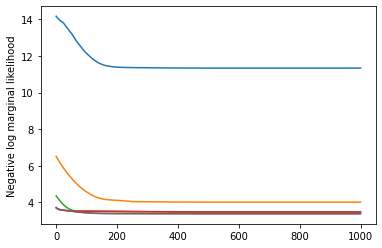

In [20]:
plt.plot(losses.T)
plt.ylabel("Negative log marginal likelihood")

## Plot marginal likelihood of each model

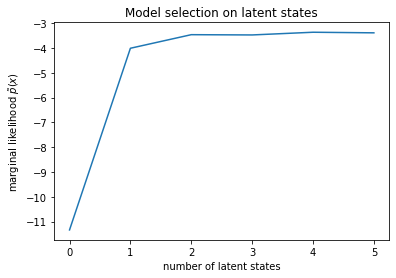

In [21]:
plt.plot(-losses[:, -1])
plt.ylabel("marginal likelihood $\\tilde{p}(x)$")
plt.xlabel("number of latent states")
plt.title("Model selection on latent states");

## Plot posteriors

In [22]:
for i, rate in enumerate(rates):
    print("rates for {}-state model: {}".format(i + 1, rate))

rates for 1-state model: [[32.607353 ]
 [ 7.3890553]
 [ 7.3890557]
 [ 7.2373586]
 [ 7.3890576]
 [ 7.3890586]]
rates for 2-state model: [[44.837685 ]
 [ 4.073831 ]
 [ 7.3890615]
 [ 7.389056 ]
 [ 7.389053 ]
 [ 7.389054 ]]
rates for 3-state model: [[47.004005 ]
 [19.221441 ]
 [ 3.536869 ]
 [ 7.3890557]
 [ 7.389057 ]
 [ 7.389057 ]]
rates for 4-state model: [[47.003456]
 [19.216593]
 [ 3.572704]
 [ 3.572704]
 [ 7.389057]
 [ 7.389057]]
rates for 5-state model: [[38.464977 ]
 [19.207113 ]
 [ 3.5727036]
 [ 3.5727043]
 [49.410873 ]
 [ 7.389058 ]]
rates for 6-state model: [[49.353485 ]
 [19.20746  ]
 [ 3.572704 ]
 [ 3.5727043]
 [49.35347  ]
 [38.462532 ]]


In [23]:
most_probable_states = vmap(partial(hmm.most_likely_states, emissions=emissions))(params)

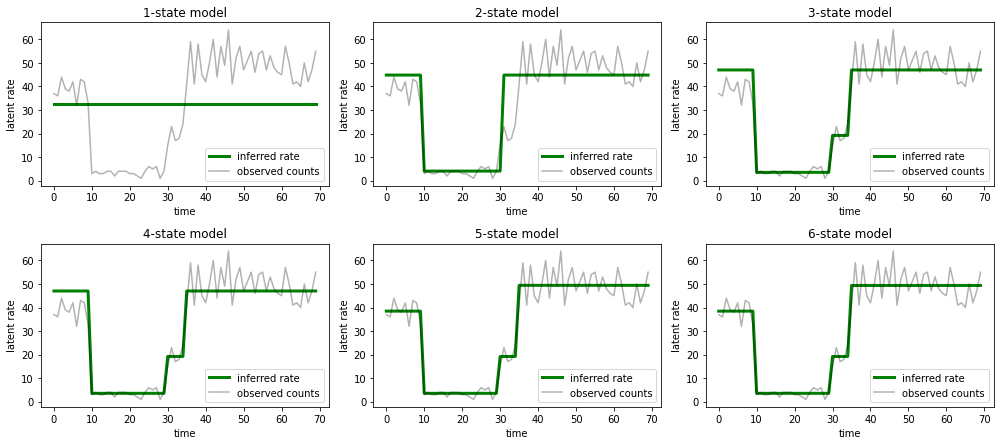

In [24]:
fig = plt.figure(figsize=(14, 12))
for i, learned_model_rates in enumerate(rates):
    ax = fig.add_subplot(4, 3, i + 1)
    ax.plot(learned_model_rates[most_probable_states[i]], c="green", lw=3, label="inferred rate")
    ax.plot(emissions, c="black", alpha=0.3, label="observed counts")
    ax.set_ylabel("latent rate")
    ax.set_xlabel("time")
    ax.set_title("{}-state model".format(i + 1))
    ax.legend(loc=4)
plt.tight_layout()